<a href="https://colab.research.google.com/github/rlmaxon/Titanic/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
#Import the libraries required to create and run model
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
# map the google colab to the google drive where the data is stored.
from google.colab import drive
drive.mount("/content/drive")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
#Read the csv data in a dataframe
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/titanic3_9nov2021.csv')


In [121]:
#sample the data with 10 rows.
df.sample(10)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
148,1.0,0.0,"Harris, Mr. Henry Birkhardt",male,45.0,1.0,0.0,36973,83.4750,C83,S,NaN,NaN,"New York, NY"
525,2.0,0.0,"Pain, Dr. Alfred",male,23.0,0.0,0.0,244278,10.5000,NaN,S,NaN,NaN,"Hamilton, ON"
462,2.0,0.0,"Jefferys, Mr. Clifford Thomas",male,24.0,2.0,0.0,C.A. 31029,31.5000,NaN,S,NaN,NaN,"Guernsey / Elizabeth, NJ"
352,2.0,1.0,"Brown, Mrs. Thomas William Solomon (Elizabeth ...",female,40.0,1.0,1.0,29750,39.0000,NaN,S,14,NaN,"Cape Town, South Africa / Seattle, WA"
335,2.0,0.0,"Bateman, Rev. Robert James",male,51.0,0.0,0.0,S.O.P. 1166,12.5250,NaN,S,NaN,174.0,"Jacksonville, FL"
194,1.0,0.0,"Maguire, Mr. John Edward",male,30.0,0.0,0.0,110469,26.0000,C106,S,NaN,NaN,"Brockton, MA"
735,3.0,1.0,"Coutts, Mrs. William (Winnie ""Minnie"" Treanor)",female,36.0,0.0,2.0,C.A. 37671,15.9000,NaN,S,2,NaN,"England Brooklyn, NY"
6,1.0,1.0,"Andrews, Miss. Kornelia Theodosia",female,63.0,1.0,0.0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
918,3.0,0.0,"Kassem, Mr. Fared",male,NaN,0.0,0.0,2700,7.2292,NaN,C,NaN,NaN,NaN
943,3.0,0.0,"Laitinen, Miss. Kristina Sofia",female,37.0,0.0,0.0,4135,9.5875,NaN,S,NaN,NaN,NaN


In [122]:
df[["pclass", "survived","age", "fare"]].describe()

,pclass,survived,age,fare
count,1309.000000,1309.000000,1046.000000,1308.000000
mean,2.294882,0.381971,29.881135,33.295479
std,0.837836,0.486055,14.413500,51.758668
min,1.000000,0.000000,0.166700,0.000000
25%,2.000000,0.000000,21.000000,7.895800
50%,3.000000,0.000000,28.000000,14.454200
75%,3.000000,1.000000,39.000000,31.275000
max,3.000000,1.000000,80.000000,512.329200


In [123]:
#check for missing values
df.isnull().sum()

pclass          1
survived        1
name            1
sex             1
age           264
sibsp           1
parch           1
ticket          1
fare            2
cabin        1015
embarked        3
boat          824
body         1189
home.dest     565
dtype: int64

In [124]:
df.drop(['home.dest','body','boat','cabin'], axis=1, inplace=True) 

In [125]:
#drop the rows with missing values.  Features like cabin, boat, body and home.dest dont have any meaning or are arbitray to analysis.
df.dropna(inplace=True)

In [126]:
#check for missing values
df.isnull().sum()

pclass      0
survived    0
name        0
sex         0
age         0
sibsp       0
parch       0
ticket      0
fare        0
embarked    0
dtype: int64

In [127]:
# get the average age by male and female
df[["age","sex"]].groupby("sex").mean()


,age
sex,
female,28.576641
male,30.539701


In [128]:
#determine the average age of suvival
df[["survived","age"]].groupby("survived").mean()

,age
survived,
0.0,30.496899
1.0,28.819020


In [129]:
#determinethe average cabin fair of survival. THis might be interesting, did people who paid more money actually survive at a higher rate?
df[["survived","fare"]].groupby("survived").mean()


,fare
survived,
0.0,25.148752
1.0,53.258883


In [130]:
# This is interesting, surviving males paid less than surviving females.  
df.groupby(["survived", "sex"])["fare"].mean()

survived  sex   
0.0       female    22.157510
          male      25.698865
1.0       female    59.423047
          male      40.017347
Name: fare, dtype: float64

In [131]:
# Females in the highest Pclass(1st class) had the best chance of survival.  Females had the best overall chance of survival and it increased based on pclass.
df.groupby(["sex","pclass"])["survived"].mean()

sex     pclass
female  1.0       0.961832
        2.0       0.893204
        3.0       0.473684
male    1.0       0.350993
        2.0       0.145570
        3.0       0.169540
Name: survived, dtype: float64

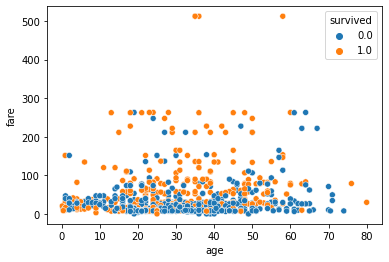

In [132]:
#scatter plot of age, fare and who survived.
 
sns.scatterplot(data=df, y="fare", x="age", hue="survived")

In [133]:
# create groups based on age of every 10 yrs.
age_groups = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
df['age_group'] = pd.cut(df.age, range(0, 81, 10), right=False, labels=age_groups)


In [134]:
# create groups based $50 of the cost of a ticket.
fare_groups = ['0-49', '50-99', '100-149', '150-199', '200-249', '250-299', '300-349', '350-399','400-449', '450-499', '500-549']
df['fare_group'] = pd.cut(df.fare, range(0, 600, 50), right=False, labels=fare_groups)

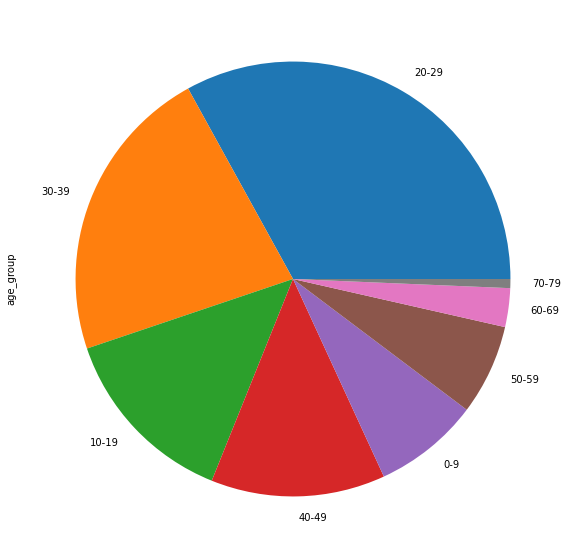

In [135]:
#Plot the age and fare groups in pie charts.  

df['age_group'].value_counts().plot.pie(figsize=(10,10))

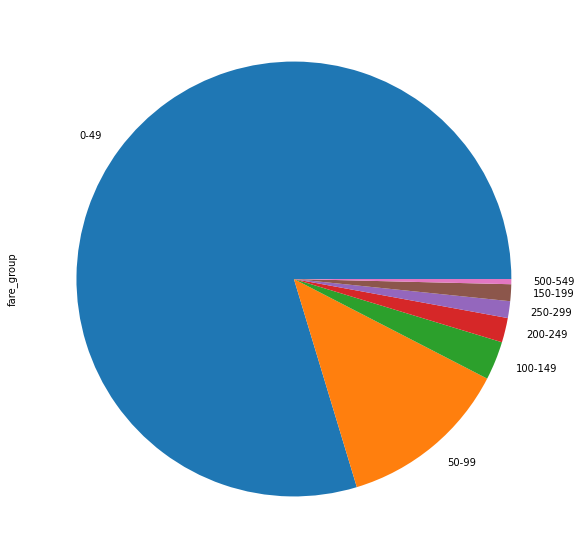

In [136]:
#Pie chart of the fares grouped by $50. Clearly the majority of ticket costs were less than $50.
df['fare_group'].value_counts().plot.pie(figsize=(10,10))

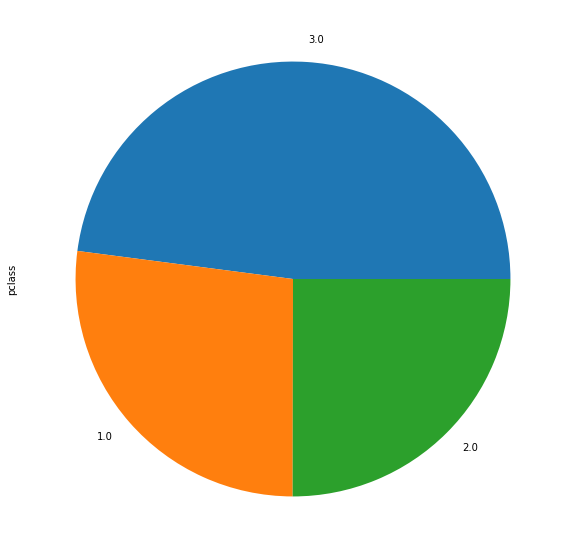

In [137]:
#The distribution of passengers by class, 1st, 2nd, and 3rd.
df['pclass'].value_counts().plot.pie(figsize=(10,10))

In [138]:
df.sample(5)


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,age_group,fare_group
1067,3.0,1.0,"Nysten, Miss. Anna Sofia",female,22.0,0.0,0.0,347081,7.75,S,20-29,0-49
470,2.0,0.0,"Keane, Mr. Daniel",male,35.0,0.0,0.0,233734,12.35,Q,30-39,0-49
1217,3.0,0.0,"Soholt, Mr. Peter Andreas Lauritz Andersen",male,19.0,0.0,0.0,348124,7.65,S,10-19,0-49
447,2.0,0.0,"Hocking, Mr. Richard George",male,23.0,2.0,1.0,29104,11.50,S,20-29,0-49
501,2.0,1.0,"Mellinger, Miss. Madeleine Violet",female,13.0,0.0,1.0,250644,19.50,S,10-19,0-49


In [139]:
df.drop(columns=['pclass','name','ticket','embarked','age_group','fare_group'], axis=1, inplace=True)

In [140]:
# The model can't work with string data, it needs to be coded with numeric values, binary since there are only 2 geners in the passenger list.
df['sex'] = df['sex'].map(dict(zip(['male','female'],[0,1])))


In [141]:
df

,survived,sex,age,sibsp,parch,fare
0,1.0,1,29.0000,0.0,0.0,211.3375
1,1.0,0,0.9167,1.0,2.0,151.5500
2,0.0,1,2.0000,1.0,2.0,151.5500
3,0.0,0,30.0000,1.0,2.0,151.5500
4,0.0,1,25.0000,1.0,2.0,151.5500
...,...,...,...,...,...,...
1301,0.0,0,45.5000,0.0,0.0,7.2250
1304,0.0,1,14.5000,1.0,0.0,14.4542
1306,0.0,0,26.5000,0.0,0.0,7.2250
1307,0.0,0,27.0000,0.0,0.0,7.2250


In [142]:
#split data into Test and train
X = df
y = df['survived']
X_train, X_test, Y_train, y_test = train_test_split(X, y, test_size=0.2)


In [143]:
X_test

,survived,sex,age,sibsp,parch,fare
356,0.0,0,25.0,0.0,0.0,13.0000
295,1.0,0,17.0,0.0,2.0,110.8833
737,0.0,0,19.0,0.0,0.0,8.1583
132,0.0,0,24.0,0.0,0.0,79.2000
110,0.0,0,30.0,0.0,0.0,27.7500
...,...,...,...,...,...,...
352,1.0,1,40.0,1.0,1.0,39.0000
728,0.0,0,43.0,0.0,0.0,8.0500
810,0.0,0,16.0,1.0,3.0,34.3750
1280,0.0,0,22.0,0.0,0.0,7.8958


In [144]:
X_test

,survived,sex,age,sibsp,parch,fare
356,0.0,0,25.0,0.0,0.0,13.0000
295,1.0,0,17.0,0.0,2.0,110.8833
737,0.0,0,19.0,0.0,0.0,8.1583
132,0.0,0,24.0,0.0,0.0,79.2000
110,0.0,0,30.0,0.0,0.0,27.7500
...,...,...,...,...,...,...
352,1.0,1,40.0,1.0,1.0,39.0000
728,0.0,0,43.0,0.0,0.0,8.0500
810,0.0,0,16.0,1.0,3.0,34.3750
1280,0.0,0,22.0,0.0,0.0,7.8958


In [145]:
X_test.drop('survived', axis=1)


,sex,age,sibsp,parch,fare
356,0,25.0,0.0,0.0,13.0000
295,0,17.0,0.0,2.0,110.8833
737,0,19.0,0.0,0.0,8.1583
132,0,24.0,0.0,0.0,79.2000
110,0,30.0,0.0,0.0,27.7500
...,...,...,...,...,...
352,1,40.0,1.0,1.0,39.0000
728,0,43.0,0.0,0.0,8.0500
810,0,16.0,1.0,3.0,34.3750
1280,0,22.0,0.0,0.0,7.8958


In [146]:
forest = RandomForestClassifier(n_estimators=50,  max_depth=9, criterion='entropy', min_samples_split = 6,
                                 min_samples_leaf=1,random_state =57)
forest.fit(X_train, y_train)

forest_accuracy = cross_val_score(forest, X_train, Y_train,  cv = 20).mean()

print('Model: Random Forest Accuracy: ', forest_accuracy)
     


forest.score(X_train, Y_train)
acc_random_forest = round(forest.score(X_train, Y_train) * 100, 2)
print(acc_random_forest)

Model: Random Forest Accuracy:  1.0
54.32


In [147]:
#predict who survives
Y_prediction = forest.predict(X_test)
print(Y_prediction)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
